In [2]:
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Import the dataset

**Add descriptions**

In [3]:
oxides = pd.read_pickle('../data/training_data.pickle')

## Get values from the dataset

In order to use values in a Pandas dataframe you need to get the values in a list.
This is realtively easy once you know the labels of the columns in the dataframe.
Here, we can look at the column names using 
```
list(df.columns)
```
where `df` is the dataframe name.

We have a lot of columns! The value that we are trying to learn is `gllbsc_gap`. The rest of the columns are potential descriptors for our ML model. To feed these to a ML model we extract the values from the columns of interest. 

In [3]:
list(oxides.columns)

['gllbsc_gap',
 '0-norm',
 '2-norm',
 '3-norm',
 '5-norm',
 '7-norm',
 '10-norm',
 'MagpieData minimum Number',
 'MagpieData maximum Number',
 'MagpieData range Number',
 'MagpieData mean Number',
 'MagpieData avg_dev Number',
 'MagpieData mode Number',
 'MagpieData minimum MendeleevNumber',
 'MagpieData maximum MendeleevNumber',
 'MagpieData range MendeleevNumber',
 'MagpieData mean MendeleevNumber',
 'MagpieData avg_dev MendeleevNumber',
 'MagpieData mode MendeleevNumber',
 'MagpieData minimum AtomicWeight',
 'MagpieData maximum AtomicWeight',
 'MagpieData range AtomicWeight',
 'MagpieData mean AtomicWeight',
 'MagpieData avg_dev AtomicWeight',
 'MagpieData mode AtomicWeight',
 'MagpieData minimum MeltingT',
 'MagpieData maximum MeltingT',
 'MagpieData range MeltingT',
 'MagpieData mean MeltingT',
 'MagpieData avg_dev MeltingT',
 'MagpieData mode MeltingT',
 'MagpieData minimum Column',
 'MagpieData maximum Column',
 'MagpieData range Column',
 'MagpieData mean Column',
 'MagpieData 

## Set up the data for a linear regression

We want to fit the model $y = f(x)$ where $y$ is `gllbsc_gap`, $x$ is one of the descriptors and $f()$ is the ML model.

To convert a column of the data to input to the ML model we can use
```
x = df['column name'].values
```

Go and set up $y$ as the `gllbsc_gap` values. For the first model, try `MagpieData avg_dev Electronegativity` for the $x$ values.

Additiobally, since this is a univariate regression and we have only one feature in $X$ we have to reshape the array. This is easy
```
X = X.reshape(-1, 1)
```

In [4]:
# Choose columns to train on
y = oxides['gllbsc_gap'].values
X = oxides['MagpieData avg_dev Electronegativity'].values
X = X.reshape(-1, 1)

## Set up and run the linear regression

* We first set up the model type
```
regr = linear_model.LinearRegression()
```
* Then we fit X versus y
```
model = regr.fit(X, y)
```
* We can get the predicted values by running the model on the training set
```
y_pred = regr.predict(X)
```
* Examine the predicted versus true values on a scatter plot.
* Calculate some performance metrics
```
metrics.mean_absolute_error(y, y_pred)
metrics.mean_squared_error(y, y_pred)
```

In [5]:
regr = linear_model.LinearRegression()
model = regr.fit(X, y)
y_pred = regr.predict(X)

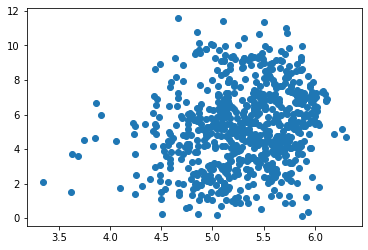

In [6]:
plt.scatter(y_pred, y)

In [7]:
metrics.mean_absolute_error(y, y_pred)

1.8339785709985128

Not great performance! Go ahead an play with some other descriptors for the X value, see if you can improve on it.

## Multi-variate regression

The next obvious step is to throw more variables into the mix. In this case you use a list of column names to define $X$:
```
X = df[['column_a', 'column_b']].values
```

* Try `MagpieData avg_dev CovalentRadius` and `MagpieData avg_dev Electronegativity`

In [8]:
X = oxides[['MagpieData avg_dev CovalentRadius', 'MagpieData avg_dev Electronegativity', 'MagpieData maximum NsValence']].values

In [9]:
regr = linear_model.LinearRegression()
model = regr.fit(X, y)
y_pred = regr.predict(X)

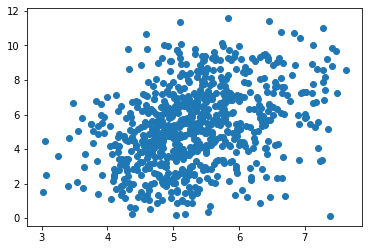

In [10]:
plt.scatter(y_pred, y)

In [11]:
metrics.mean_absolute_error(y, y_pred)

1.7408377283845773

### Lets try some combinatorics on descriptors

We can use `itertools` to build all possible combinations of three descriptors. The syntax for building a list of combinations is 
```
l = list(itertools.combinations(original_list, size_of_combo))
```
where `size_of_combo` is the number of elements per combination. [Web page for combinations](https://docs.python.org/2/library/itertools.html#itertools.combinations)

When you have build this list try fitting models on a selected sample of the combinations. **Note** do not try to fit to all combinations - there are too many for a short session. Perhaps choose the first 10 or 20 from the list.

Get the `mean_absolute_error` of each model and then take the model with the lowest $MAE$. Plot it, how does it look? There should be improvement with more features.

In [ ]:
cols = [a for a in list(oxides.columns) if a not in ['gllbsc_gap']]
pairs = list(itertools.combinations(cols, 4))

In [ ]:
loss = []
for p in pairs[:20]:
    X = oxides[list(p)].values
    model = regr.fit(X, y)
    y_pred = regr.predict(X)
    loss.append(metrics.mean_absolute_error(y, y_pred))

In [ ]:
print('Minimum loss: {} for combination: {}'.format(min(loss), list(pairs[np.argmin(loss)])))

In [ ]:
plt.scatter(y_pred, y)

### Validation

As we add more parameters we increase the danger of overfitting. So we need to keep some of out data for validation. We can use the `scikit-learn` function `train_test_split` to split up our data set.
```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
```
Then train the model on the training set and predict on the test set. Compare the $MAE$ of training and test. In general the test loss will be worse than the training loss, due to some degree of overfitting.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)
model = regr.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae_tr = metrics.mean_absolute_error(y_train, y_pred)
y_pred = model.predict(X_test)
mae_te = metrics.mean_absolute_error(y_test, y_pred)
print('Training loss {}, test loss {}'.format(mae_tr, mae_te))

Training loss 1.7239847504357213, test loss 1.812473804652958


### Cross validation

By partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

* A model is trained using $(k-1)$ of the folds as training data;
* the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

This is easily implemented in `scikit-learn` using the `cross_val_score` function.
```
scores = cross_val_score(model, X, y, cv=k, scoring='method')
```
`k` is the order of the cross-validation, 5 will work here. `method` is the metric to use, we use `neg_mean_absolute_error`. Run the cross validation and get the mean of `scores`.

In [13]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regr, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation score {}'.format(-1 * np.mean(scores)))

Cross validation score 1.7792806120099116


## More complex models

So far we have been working with linear regression models. As you can see for multivariate linear regression there are a huge combination of models possible and serarching through all combinations quickly becomes infeasible. We will now use two of the model types that you learned about during the lectures. 

* A gradient boosted decision tree
* A support vector machine

### Gradient Boosting Regression

Gradient bosting is a method for building an ensemble of weak learners to constitute a single strong learner. We build a series of decision tree models, each subsequent decision tree is built using information about the residuals (errors) from the previous models, in principle the model gets better and better each time you add a new decision tree.  

The number of boosting steps to use is set by the `n_estimators` variable. Be aware though - simply adding more and more trees can lead you into overfitting. Gradient boosting is quite robust against overfitting, but we will have to look out for this!

```
gbr = ensemble.GradientBoostingRegressor(loss=<str>, max_depth = <int>, learning_rate = <float>,
                                        min_samples_split = <int>, min_samples_leaf = <int>, 
                                        max_features = <int>, subsample = <float>, n_estimators = <int>)
```

The parameters we need to set:

* loss: loss function to be optimized. We will use 'lad', which is basically $MAE$
* max_depth:  The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables. For now we will use 10, we will do some tuning later.
* learning_rate:learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators. We can tune this later, for now we use 0.015.
* min_samples_split:The minimum number of samples required to split an internal node. We can tune this later, for now we use 50.
* min_samples_leaf:The minimum number of samples required to be at a leaf node. We set this as 1.
* max_features: The number of features to consider when looking for the best split. We will set this as the number of features that we have.
* subsample: The fraction of samples to be used for fitting the individual trees. If smaller than 1.0 this results in Stochastic Gradient Boosting. We will use 0.9 for now, we can possibly tune this later.
* n_estimators: The number of boosting steps to use. We will start by using 300.

When you have defined the model, do the fitting
```
gbr.fit(X, y)
```
Then, using the cross validation methods from earlier do a 5 fold cross validation.

Plot the predicted against the actual band gaps.

Hopefully there is a big improvement over linear regression!

In [14]:
from sklearn import ensemble

cols = [a for a in list(oxides.columns) if a not in ['gllbsc_gap']]
X = oxides[cols].values

# Define the model hyperparameters and fit the model
gbr = ensemble.GradientBoostingRegressor(loss='lad', max_depth = 10, learning_rate = 0.015,
                                        min_samples_split = 50, min_samples_leaf = 1, 
                                        max_features = len(cols), subsample = 0.9, 
                                         n_estimators = 300)
gbr.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.015, loss='lad',
                          max_depth=10, max_features=148, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=50,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
scores = cross_val_score(gbr, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation score {}'.format(-1 * np.mean(scores)))

Cross validation score 0.931463077920119


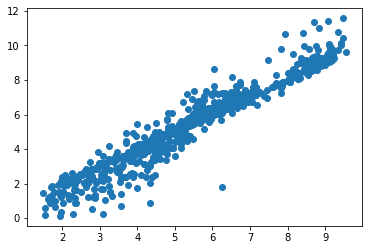

In [16]:
y_pred = gbr.predict(X)
plt.scatter(y_pred, y)

### Look out for the boosting rate and  overfitting

Let's split the data 80:20 into training and test. Re-fit the `gbr` model using the training data only.

We can then use some built in methods of the gradient boosted regressorr to get training and test scores at each iteration of boosting. So we can check if we have enough boosting layers or perhaps we have too many and we are over-fitting.


The performance of the training data at each step is obtained from
```
gbr.train_score_
```
Getting the score on the test data is a little more complex, but not much!
```
test_score = np.zeros((300,), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)
```
Here we have built an array called `test_score` to store the loss values

You can now plot the training and test scores on the same plot.

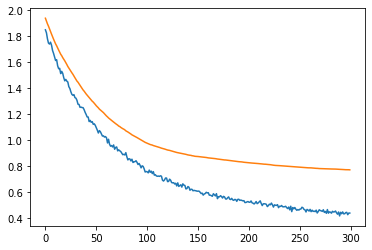

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
gbr.fit(X_train, y_train)

test_score = np.zeros((300,), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)
plt.plot( gbr.train_score_)
plt.plot(test_score)

### Extend the bosting

Maybe you noticed that the loss of both training and test are still decreasing at 300 steps. We can try to extend the numbe rof boosting steps and see if we still get improvement, try the same as above, but with `n_estimators` set to 500.

If the test score stops increasing then we are probably in a good place to stop extending the model. Do a 5-fold cross validation at this point. How does the score compare to the earlier score?

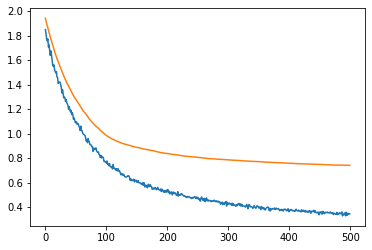

In [19]:
# Define the model hyperparameters and fit the model
gbr1 = ensemble.GradientBoostingRegressor(loss='lad', max_depth = 10, learning_rate = 0.015,
                                        min_samples_split = 50, min_samples_leaf = 1, 
                                        max_features = len(cols), subsample = 0.9, 
                                         n_estimators = 500)
gbr1.fit(X_train, y_train)

test_score = np.zeros((500,), dtype=np.float64)
for i, y_pred in enumerate(gbr1.staged_predict(X_test)):
    test_score[i] = gbr1.loss_(y_test, y_pred)
plt.plot( gbr1.train_score_)
plt.plot(test_score)

In [20]:
scores = cross_val_score(gbr1, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation score {}'.format(-1 * np.mean(scores)))

Cross validation score 0.9199637427938476


### Systematic hyperparameter tuning

Obvioulsy there are a lot of hyperparameters and tuning by hand will take a lot of effort. Luckily `scikit-learn` has a function `GridSearchCV` that allows us to set up systematic searches of hyperparameter space.

Performing a gridserach of all of the parameters at once would again lead to a combinatorial explosion. A general strategy for tuning hyperparameters in gradient boosted trees [has been suggested](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) 


   * Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems
   * Determine the optimum number of trees for this learning rate. This should range around 40 - 90. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.
   * Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
   * Lower the learning rate and increase the estimators proportionally to get more robust models.
   
Try this out using [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Setting up `GridSearchCV`

* set up the parameters we want to search over in a dictionary.
* set up the model with the remaining parameters that you do no want to vary
* define the grid search object
* fit 


```
from sklearn.model_selection import GridSearchCV
search_params = {<param_1>:[values], <param_2>:[values]....}
gbr = ensemble.GradientBoostingRegressor(<params>)
gsearch = GridSearchCV(estimator = gbr, param_grid = search_params, 
                      scoring = 'neg_median_absolute_error', cv=5)
gsearch.fit(X, y)
```
 
* `<param_n>` string, the names of the parameters that you want to vary
* `[values]` a list of the values that you want to use in the grid search
* `<params>` strings and values, the remaining parameters of the grid search, these stay fixed

### Optimise `n_estimators`

Try a range of 125 - 220 in steps of 10.

In [21]:
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':range(125, 220, 10)}
gbr1 = ensemble.GradientBoostingRegressor(loss='lad',learning_rate=0.1, 
                                  max_features=len(cols), max_depth = 10,
                                  min_samples_split = 50,
                                  subsample=0.9)
gsearch = GridSearchCV(estimator= gbr1, param_grid = param_test1, 
                       scoring='neg_median_absolute_error',
                       iid=False, cv=5)
gsearch.fit(X, y)

/home/mts87985/src/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='lad', max_depth=10,
                                                 max_features=148,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=50,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
               

In [22]:
gsearch.best_params_

{'n_estimators': 205}

### Optimise tree parameters

Try varying `max_depth` between 5 - 16 in steps of 2, and `min_samples_split` between 20 and 1000 in steps of 200.

In [23]:
param_test2 = {'max_depth':range(5, 16, 2), 'min_samples_split':range(20,100,200)}
gbr2 = ensemble.GradientBoostingRegressor(loss='lad',learning_rate=0.1, 
                                 n_estimators=205, max_features=len(cols), 
                                 subsample=0.9)
gsearch = GridSearchCV(estimator= gbr2, param_grid = param_test2, 
                       scoring='neg_median_absolute_error',
                       iid=False, cv=5)
gsearch.fit(X, y)


/home/mts87985/src/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='lad', max_depth=3,
                                                 max_features=148,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=205,
                                                 n_iter_no_change=None,
                 

In [ ]:
param_test2 = {'max_depth':range(15, 36, 2)}
gbr2 = ensemble.GradientBoostingRegressor(loss='lad',learning_rate=0.1, 
                                 n_estimators=185, max_features=len(cols), 
                                 min_samples_split=20,
                                 subsample=0.9)
gsearch = GridSearchCV(estimator= gbr2, param_grid = param_test2, 
                       scoring='neg_median_absolute_error',
                       iid=False, cv=5)
gsearch.fit(X, y)

In [24]:
print('Acheived a top score of MAE = {0:6.3f} eV using parameters: {1}'.format(gsearch.best_score_, gsearch.best_params_))

Acheived a top score of MAE = -0.674 eV using parameters: {'max_depth': 13, 'min_samples_split': 20}


In [32]:
gbr3.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad',
                          max_depth=13, max_features=148, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=20,
                          min_weight_fraction_leaf=0.0, n_estimators=205,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
scores = cross_val_score(gbr3, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation score {}'.format(-1 * np.mean(scores)))

Cross validation score 0.8998802190759493


## Save the model - we will use it later on.

In [36]:
import pickle
filename = '../models/gb_tree_best.pkl'
pickle.dump(gbr3, open(filename, 'wb'))